In [ ]:
"""
CS895_Computational_Imaging_Spring_2025__
|
DNA_DAMAGE_QUANTIFICATION (DDQ)
CS895_CI_ddq_custom_model_training.ipynb
Created on Tue Feb 25 18:23:59 2025
@authors: Rochana Obadage and Kumushini Thennakoon
|
Referenced from: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb
"""


# cellpose 3.1

We will first install cellpose 3.1, check the GPU is working, and mount google drive to get your models and images.

## Installation

In [7]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)


In [6]:
!pip uninstall -y opencv-python-headless
!pip uninstall -y cellpose
!pip uninstall -y numpy


Found existing installation: opencv-python-headless 3.4.18.65
Uninstalling opencv-python-headless-3.4.18.65:
  Successfully uninstalled opencv-python-headless-3.4.18.65
Found existing installation: cellpose 4.0.6
Uninstalling cellpose-4.0.6:
  Successfully uninstalled cellpose-4.0.6
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [8]:
!pip install "opencv-python-headless<4.3"
!pip install "cellpose==3.1.1"

  Using cached opencv_python_headless-3.4.18.65-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached opencv_python_headless-3.4.18.65-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45.7 MB)
  Using cached cellpose-3.1.1-py3-none-any.whl.metadata (22 kB)
Using cached cellpose-3.1.1-py3-none-any.whl (225 kB)


New code 

In [9]:
# !nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

from natsort import natsorted

# import matplotlib.pyplot as plt
# import numpy as np
# from skimage import io


use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

Tue Sep 30 10:16:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   38C    P8             12W /  285W |    3222MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
# Update paths to match your actual folder structure
train_files = natsorted(glob('train/*.tif'))
train_seg = natsorted(glob('train/*_seg.npy'))

test_files = natsorted(glob('test/*.tif'))
test_seg = natsorted(glob('test/*_seg.npy'))

# Print the files found to verify paths
print("Training files found:")
for f in train_files:
    print(f"  {f}")
    
print("\nTraining segmentation files found:")
for f in train_seg:
    print(f"  {f}")
    
print("\nTest files found:")
for f in test_files:
    print(f"  {f}")
    
print("\nTest segmentation files found:")
for f in test_seg:
    print(f"  {f}")

Training files found:
  train/4Gy_53BP1_1Hr.tif
  train/4Gy_53BP1_4Hr.tif
  train/4Gy_gH2AX_1Hr.tif
  train/4Gy_gH2AX_4Hr.tif
  train/8Gy_53BP1_1Hr.tif
  train/8Gy_53BP1_4Hr.tif
  train/8Gy_gH2AX_1Hr.tif

Training segmentation files found:
  train/4Gy_53BP1_1Hr_seg.npy
  train/4Gy_53BP1_4Hr_seg.npy
  train/4Gy_gH2AX_1Hr_seg.npy
  train/4Gy_gH2AX_4Hr_seg.npy
  train/8Gy_53BP1_1Hr_seg.npy
  train/8Gy_53BP1_4Hr_seg.npy
  train/8Gy_gH2AX_1Hr_seg.npy

Test files found:
  test/4Gy_53BP1_8Hr.tif
  test/4Gy_gH2AX_8Hr.tif
  test/8Gy_53BP1_8Hr.tif
  test/8Gy_gH2AX_8Hr.tif

Test segmentation files found:
  test/4Gy_53BP1_8Hr_seg.npy
  test/4Gy_gH2AX_8Hr_seg.npy
  test/8Gy_53BP1_8Hr_seg.npy
  test/8Gy_gH2AX_8Hr_seg.npy


`what the training images look like + their labels`

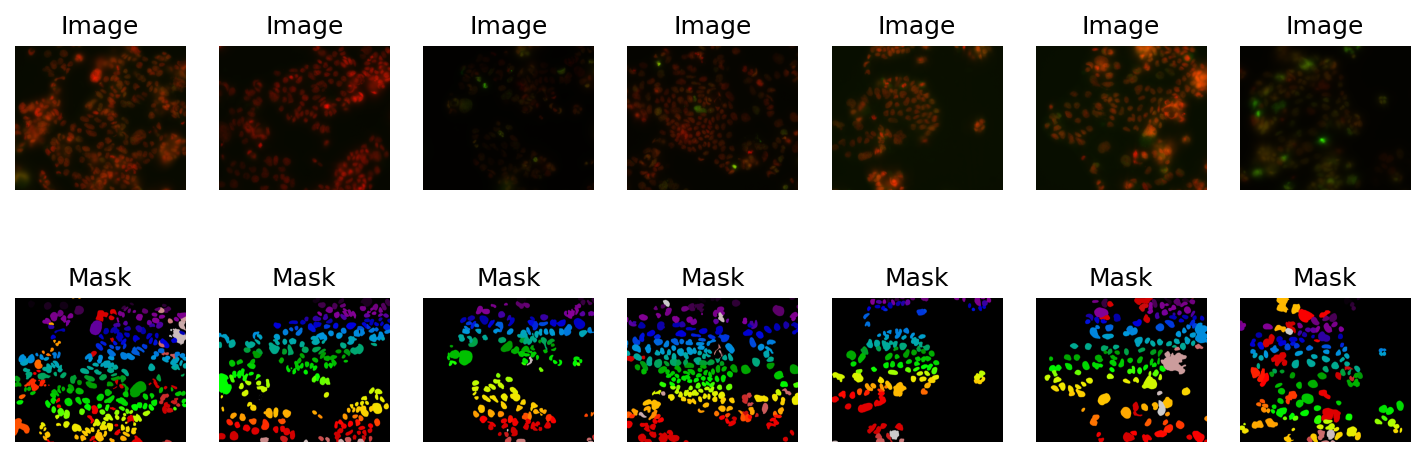

In [12]:
# %matplotlib inline
plt.figure(figsize=(12, 4), dpi=150)

for k, f in enumerate(train_files):
    # Load image
    img = io.imread(f)

    # Normalize image if needed
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # scale to [0, 1]

    # Plot image
    plt.subplot(2, len(train_files), k + 1)
    img = np.vstack((img, np.zeros_like(img)[:1]))  # Optional: remove if not needed
    img = img.transpose(1, 2, 0) if img.ndim == 3 else img
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")

    # Load and plot mask
    plt.subplot(2, len(train_files), len(train_files) + k + 1)
    seg_path = os.path.splitext(f)[0] + '_seg.npy'
    seg = np.load(seg_path, allow_pickle=True).item()
    masks = seg['masks'].squeeze()
    plt.imshow(masks, cmap='nipy_spectral')  # color-coded mask
    plt.axis('off')
    plt.title("Mask")


# Train model on manual annotations

## Training parameters

<font size = 2> **Paths for training, predictions and results**


<font size = 2>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images).

<font size = 2>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 2>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 2>**Training parameters**

<font size = 2>**`number_of_epochs`:** Input how many epochs the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [14]:
train_dir = "train" 
test_dir = "test" 

#Define where the patch file will be saved
base = "cellpose"

# model name and path
from cellpose import models
initial_model = "nuclei" # ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "ddq_model_1"

# other parameters for training.
n_epochs =  100
Channel_to_use_for_training = "Red" # ["Grayscale", "Blue", "Green", "Red"]

# If you have a secondary channel that can be used for training, for instance nuclei, choose it here:
Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

# Advanced Parameters
Use_Default_Advanced_Parameters = True
learning_rate = 0.1 
weight_decay = 0.0001 

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = 'custom_models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [5]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)

python -m cellpose --use_gpu --verbose --train --dir train --pretrained_model nuclei --chan 1 --chan2 0 --n_epochs 100 --learning_rate 0.1 --weight_decay 0.0001 --test_dir test --mask_filter _seg.npy


## Train new model

Using settings from form above, train model in notebook.

In [16]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=model_path,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

2025-09-30 10:20:48,349 [INFO] WRITING LOG OUTPUT TO /home/cse/.cellpose/run.log
2025-09-30 10:20:48,350 [INFO] 
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.12.3 
torch version:  	2.8.0+cu128
2025-09-30 10:20:48,351 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-09-30 10:20:48,362 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 10:20:48,362 [INFO] >>>> using GPU (CUDA)
2025-09-30 10:20:49,340 [INFO] >>>> loading model /home/cse/.cellpose/models/cpsam
2025-09-30 10:20:49,590 [INFO] not all flows are present, running flow generation for all images
2025-09-30 10:20:49,733 [INFO] 7 / 7 images in train folder have labels
2025-09-30 10:20:49,734 [INFO] not all flows are present, running flow generation for all images
2025-09-30 10:20:49,957 [INFO] 4 / 4 images in test folder have labels
2025-09-30 10:20:49,958 [INFO] computing flows for labels


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]

2025-09-30 10:21:02,057 [INFO] computing flows for labels



100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

2025-09-30 10:21:07,498 [INFO] >>> computing diameters



100%|██████████| 4/4 [00:00<00:00, 94.45it/s]

2025-09-30 10:21:07,617 [INFO] >>> using channels [1, 0]
2025-09-30 10:21:07,617 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


TypeError: convert_image() got an unexpected keyword argument 'channels'

# Training Loss Visualization

Plot the training and validation loss curves to analyze model convergence and performance.

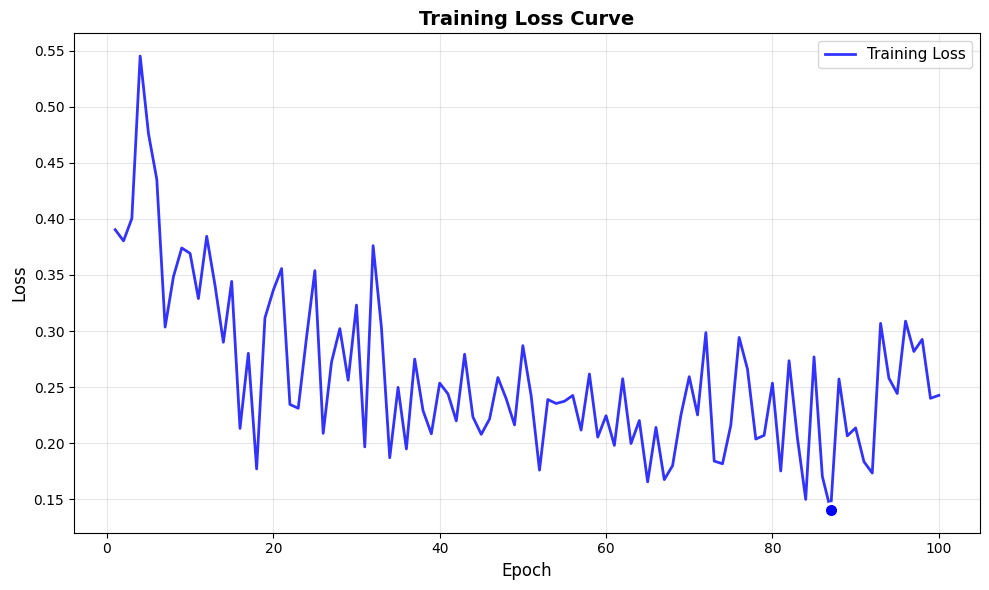

🔬 TRAINING PERFORMANCE ANALYSIS
📊 LOSS STATISTICS:
   Training epochs:        100
   Final training loss:    0.2427
   Best training loss:     0.1404 (epoch 87)

📈 LEARNING PROGRESS:
   Training loss reduction: 37.8%


In [32]:
# Create training loss plot for the trained DDQ model
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Training Loss Plot only
epochs = np.arange(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Highlight minimum loss point
min_train_idx = np.argmin(train_losses)
plt.scatter(min_train_idx + 1, train_losses[min_train_idx], 
           color='blue', s=100, marker='o', edgecolor='white', linewidth=2, zorder=5)

plt.tight_layout()
plt.show()

# Print basic training statistics
print("🔬 TRAINING PERFORMANCE ANALYSIS")
print("=" * 50)

print(f"📊 LOSS STATISTICS:")
print(f"   Training epochs:        {len(train_losses)}")
print(f"   Final training loss:    {train_losses[-1]:.4f}")
print(f"   Best training loss:     {np.min(train_losses):.4f} (epoch {np.argmin(train_losses) + 1})")

print(f"\n📈 LEARNING PROGRESS:")
initial_train = train_losses[0]
final_train = train_losses[-1]

train_improvement = ((initial_train - final_train) / initial_train) * 100

print(f"   Training loss reduction: {train_improvement:.1f}%")

print("=" * 50)

## Evaluate on test data (optional)

If you have test data, check performance

In [ ]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data,
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2025-09-30 08:55:57,730 [INFO] not all flows are present, running flow generation for all images
2025-09-30 08:55:57,900 [INFO] 4 / 4 images in test folder have labels
2025-09-30 08:55:57,901 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2025-09-30 08:55:57,900 [INFO] 4 / 4 images in test folder have labels
2025-09-30 08:56:05,780 [INFO] 100%|##########| 4/4 [00:07<00:00,  1.97s/it]

>>> average precision at iou threshold 0.5 = 1.000

>>> average precision at iou threshold 0.5 = 1.000


plot masks

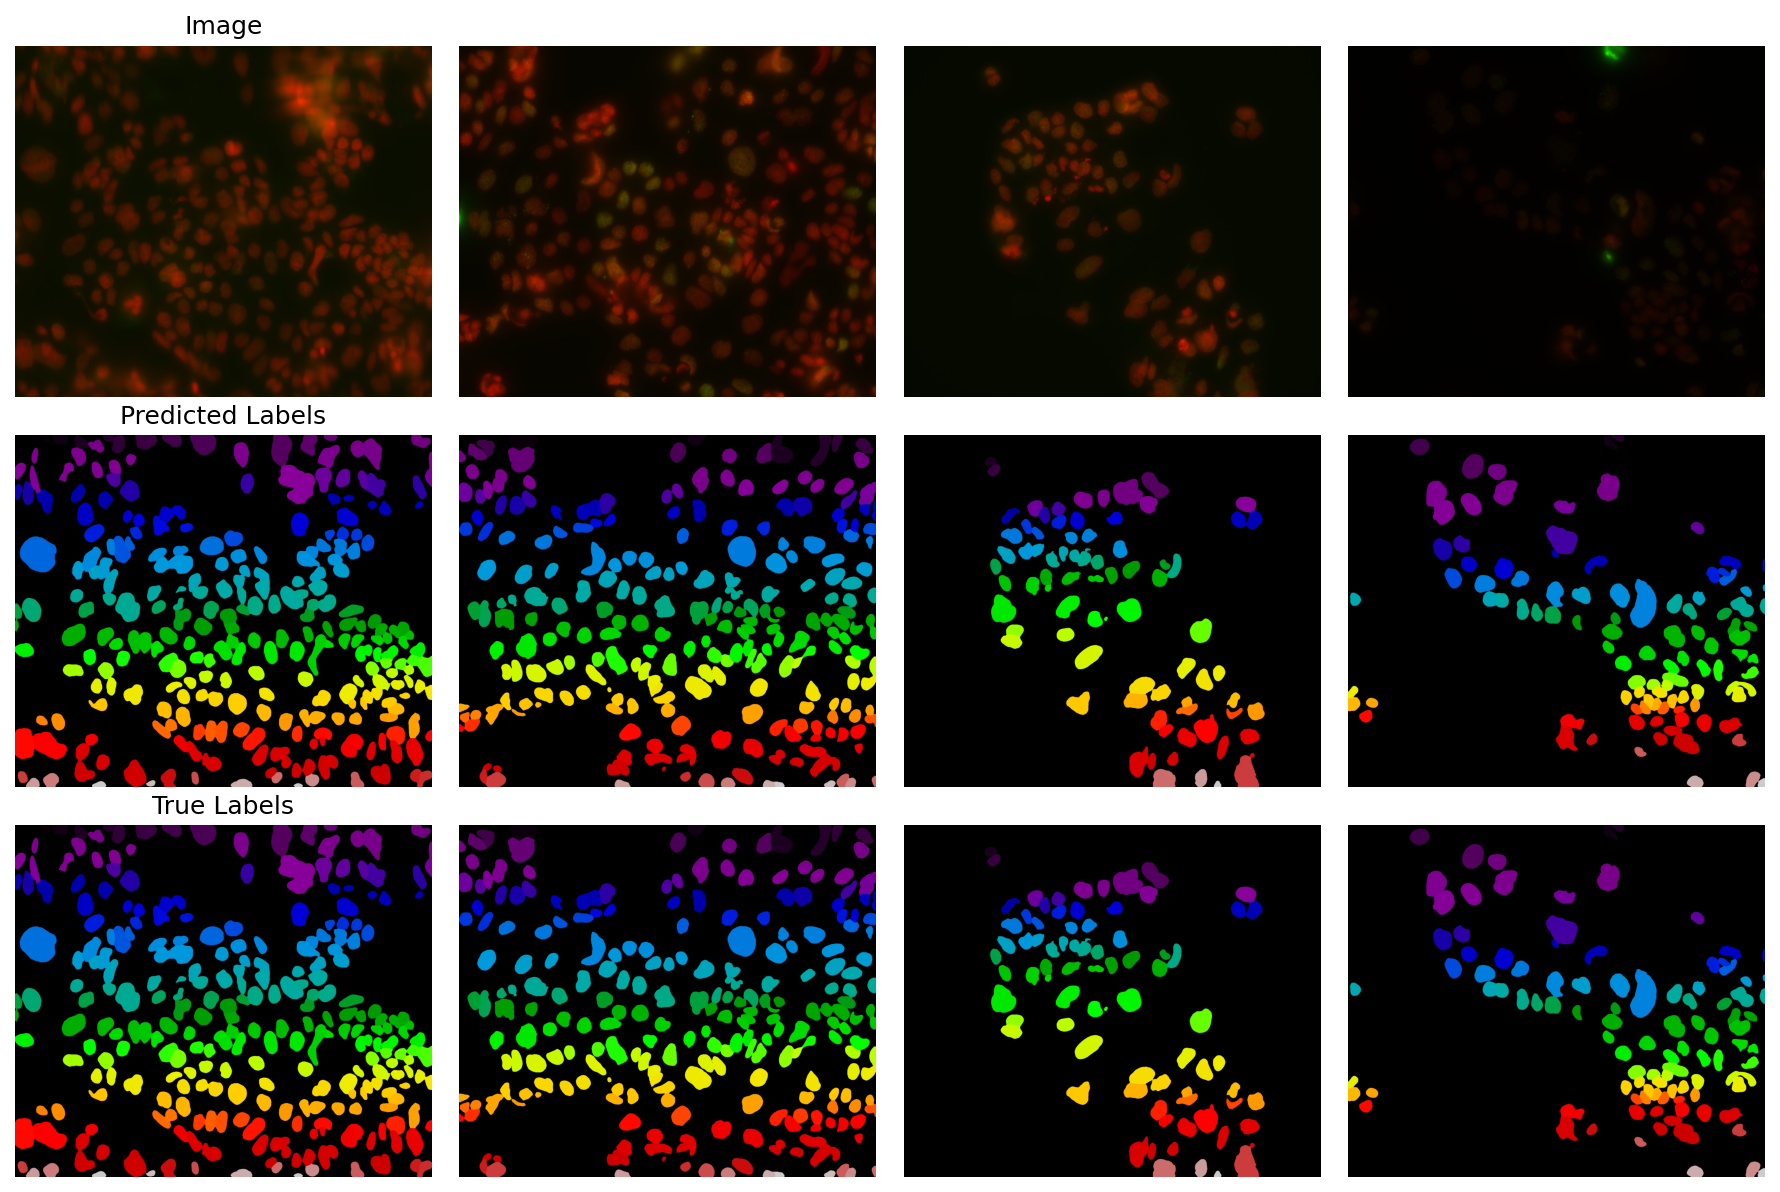

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8), dpi=150)

for k, im in enumerate(test_data):
    # Copy image and normalize if needed
    img = im.copy()
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # Normalize to [0,1]

    # Optional padding (can remove if unnecessary)
    img = np.vstack((img, np.zeros_like(img)[:1]))

    # Transpose if in (C, H, W) format
    if img.ndim == 3 and img.shape[0] <= 4:
        img = img.transpose(1, 2, 0)

    # Plot original image
    plt.subplot(3, len(test_data), k + 1)
    plt.imshow(img)
    plt.axis('off')
    if k == 0:
        plt.title('Image')

    # Plot predicted mask
    plt.subplot(3, len(test_data), len(test_data) + k + 1)
    plt.imshow(masks[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('Predicted Labels')

    # Plot ground truth
    plt.subplot(3, len(test_data), 2 * len(test_data) + k + 1)
    plt.imshow(test_labels[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('True Labels')

plt.tight_layout()
plt.show()


# Use custom model to segment images

In [14]:
model_path = "custom_models/models/ddq_model_1"
image_dir = "test"  # Updated to use your existing test directory

# Channel Parameters:

Channel_to_use_for_segmentation = "Red" # ["Grayscale", "Blue", "Green", "Red"]
Second_segmentation_channel= "None" # ["None", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

# Segmentation parameters:
# diameter of cells (set to zero to use diameter from training set):
diameter =  0 # {type:"number"}

# threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 # {type:"slider", min:0.0, max:3.0, step:0.1}

# threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 # {type:"slider", min:-6, max:6, step:1}

In [25]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {image_dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

python -m cellpose --use_gpu --verbose --dir dataset/create_new_labels --pretrained_model custom_models/models/ddq_model_1 --chan 1 --chan2 0 --diameter 0 --flow_threshold 0.4 --cellprob_threshold 0


## run custom model

In [15]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(image_dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['test/4Gy_53BP1_8Hr.tif', 'test/4Gy_gH2AX_8Hr.tif', 'test/8Gy_53BP1_8Hr.tif', 'test/8Gy_gH2AX_8Hr.tif']
2025-09-30 08:58:04,464 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 08:58:04,464 [INFO] >>>> using GPU (CUDA)
2025-09-30 08:58:04,464 [INFO] >>>> using GPU (CUDA)
2025-09-30 08:58:04,491 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-09-30 08:58:04,491 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-09-30 08:58:04,516 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 08:58:04,517 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
2025-09-30 08:58:04,518 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2025-09-30 08:58:04,516 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 08:58:04,517 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
2025-09-30 08:58:04,518 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]


['test/4Gy_53BP1_8Hr.tif', 'test/4Gy_gH2AX_8Hr.tif', 'test/8Gy_53BP1_8Hr.tif', 'test/8Gy_gH2AX_8Hr.tif']
2025-09-30 08:58:04,464 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 08:58:04,464 [INFO] >>>> using GPU (CUDA)
2025-09-30 08:58:04,464 [INFO] >>>> using GPU (CUDA)
2025-09-30 08:58:04,491 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-09-30 08:58:04,491 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-09-30 08:58:04,516 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 08:58:04,517 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
2025-09-30 08:58:04,518 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2025-09-30 08:58:04,516 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 08:58:04,517 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
2025-09-30 08:58:04,518 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]


2025-09-30 08:58:12,087 [INFO] 100%|##########| 4/4 [00:07<00:00,  1.89s/it]


## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [16]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      files,
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)),
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [21]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

In [22]:
files[3]

'test/8Gy_gH2AX_8Hr.tif'

(-0.5, 3599.5, 899.5, -0.5)

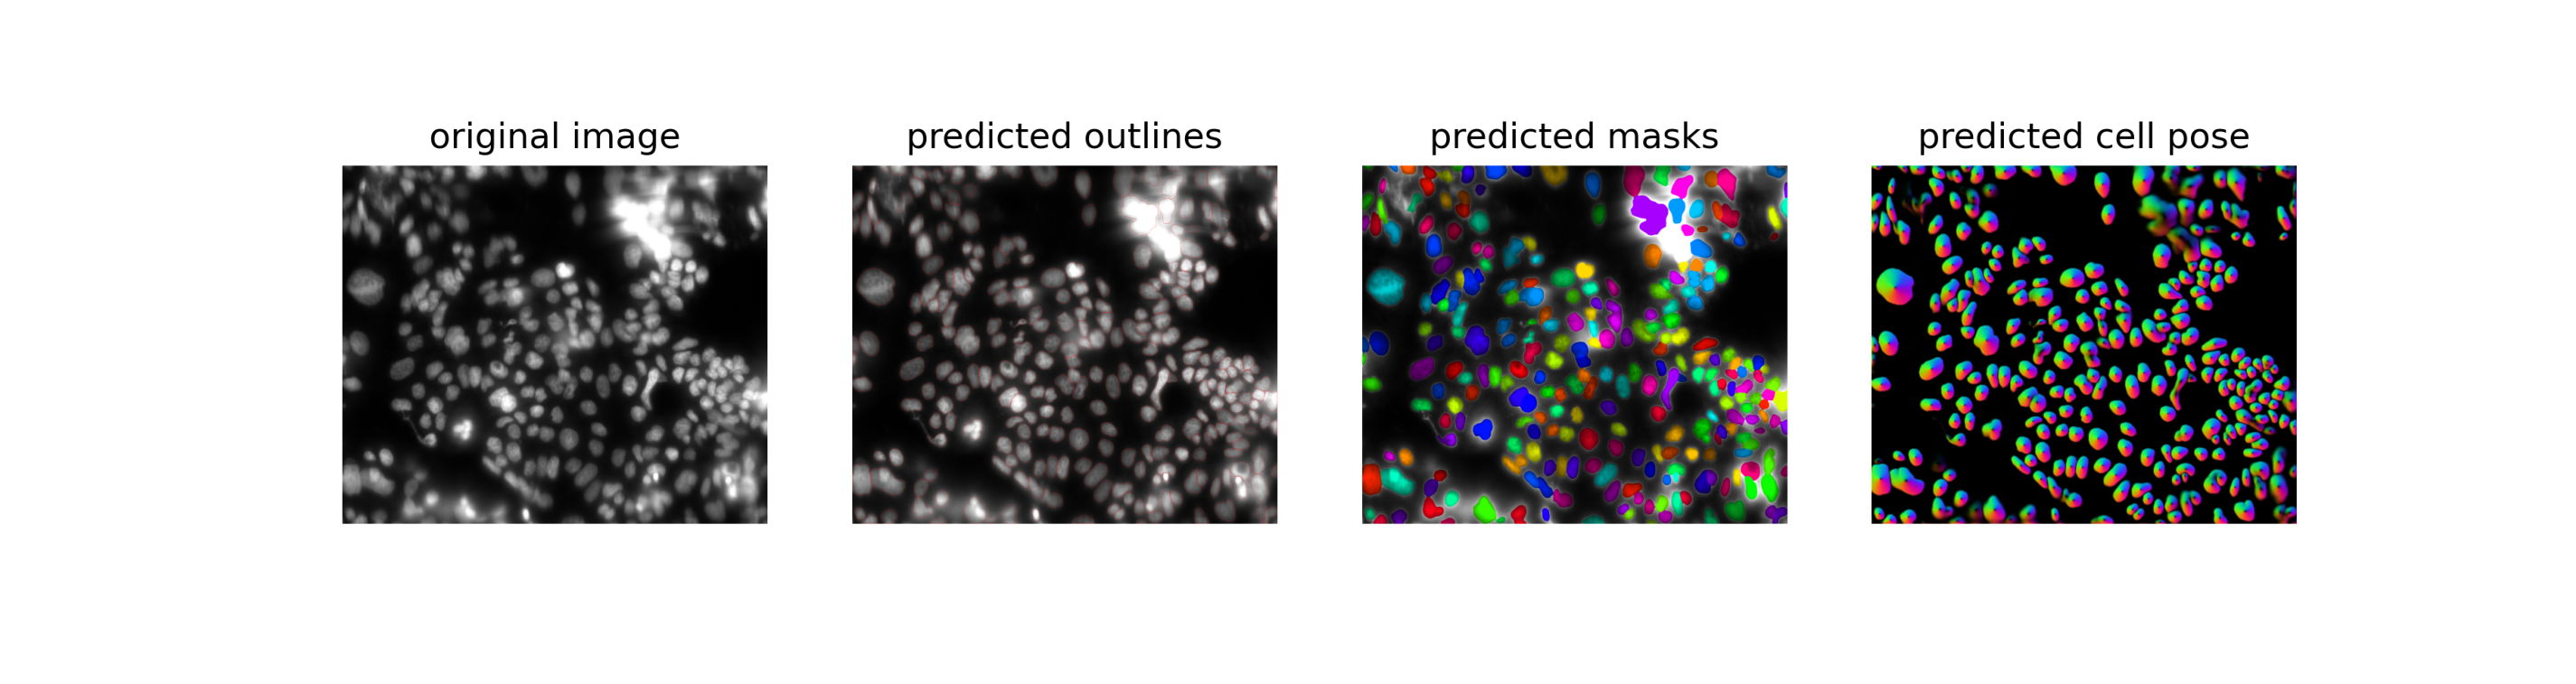

In [23]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output_cp_masks.png'))
plt.axis('off')

## .npy visualization

Image shape: (2160, 2560, 2) - 2 channels
Masks shape: (2160, 2560)
Number of cells detected: 269


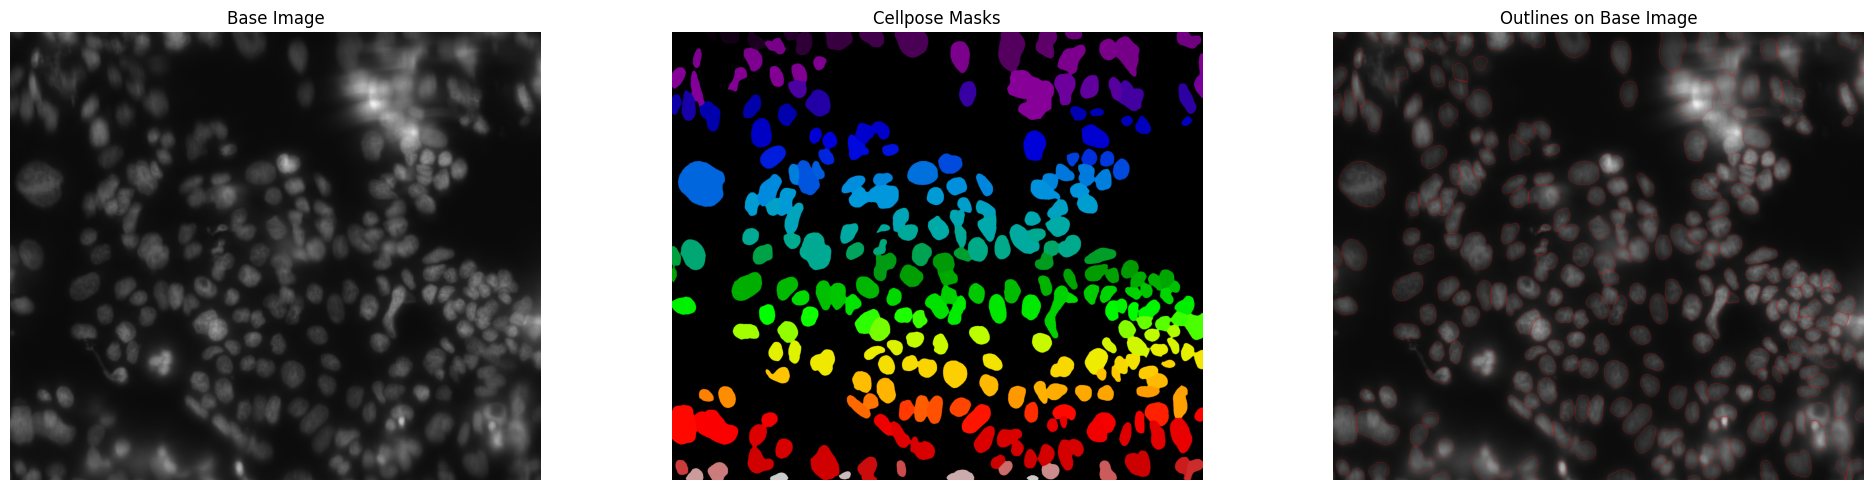

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.segmentation import find_boundaries
from cellpose import plot

# Load TIFF image - use one of your actual test files
img_name = 'test/4Gy_53BP1_8Hr'  # Updated to use your actual test directory
img = imread(f'{img_name}.tif')

# Handle (C, H, W) TIFFs
if img.ndim == 3 and img.shape[0] <= 4:
    img = np.moveaxis(img, 0, -1)

# At this point img shape should be (H, W, C)
H, W = img.shape[:2]
if img.ndim == 3:
    C = img.shape[2]
    print(f"Image shape: {img.shape} - {C} channels")
else:
    print(f"Image shape: {img.shape} - grayscale")
    # Convert grayscale to RGB for visualization
    img = np.stack([img] * 3, axis=-1)

# Use first channel (or grayscale) as base for visualization
if img.ndim == 3:
    base_img = img[..., 0]  # First channel
else:
    base_img = img

# Normalize if needed
if base_img.max() > 255:
    base_img = (base_img / base_img.max() * 255).astype(np.uint8)
else:
    base_img = base_img.astype(np.uint8)

# Convert to RGB (grayscale stacked 3 times)
img_rgb = np.stack([base_img] * 3, axis=-1)  # shape (H, W, 3)

# Load Cellpose outputs - use the _seg.npy file generated by your custom model
seg_data = np.load(f'{img_name}_seg.npy', allow_pickle=True).item()
masks = seg_data['masks']
flows = seg_data['flows']

print(f"Masks shape: {masks.shape}")
print(f"Number of cells detected: {len(np.unique(masks)) - 1}")  # -1 to exclude background

# Generate boundaries (outlines)
outlines = find_boundaries(masks, mode='inner')  # Generates boolean mask of boundaries

# Draw red outlines on the image
img_outline = img_rgb.copy()
img_outline[outlines] = np.array([255, 0, 0], dtype=np.uint8)  # Red color for outlines

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot the original base image
axs[0].imshow(img_rgb)
axs[0].set_title("Base Image")
axs[0].axis('off')

# Plot the Cellpose masks
axs[1].imshow(masks, cmap='nipy_spectral')
axs[1].set_title("Cellpose Masks")
axs[1].axis('off')

# Plot the outlines on the original image
imsave(f'{img_name}_outline.png',img_outline)
axs[2].imshow(img_outline)
axs[2].set_title("Outlines on Base Image")
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Model Comparison: Custom vs Original

Compare the performance of your custom trained DDQ model with the original pre-trained nuclei model.

In [26]:
# Load test image
test_img_path = 'test/4Gy_53BP1_8Hr.tif'
test_image = io.imread(test_img_path)

print(f"Test image: {test_img_path}")
print(f"Image shape: {test_image.shape}")

# 1. Run original pre-trained nuclei model with CORRECTED parameters
print("\n=== Running Original Nuclei Model (CORRECTED) ===")
original_model = models.CellposeModel(gpu=True, model_type='nuclei')

# Fix the main issues: diameter mismatch and optimize parameters for DDQ images
original_masks, original_flows, original_styles = original_model.eval([test_image],
                                                                     channels=[chan, chan2],  # Keep same channels as custom model
                                                                     diameter=85.0,  # Use diameter matching your cell size (not default 17)
                                                                     flow_threshold=0.4,  # Keep same as custom model
                                                                     cellprob_threshold=0)  # Keep same as custom model

print(f"Original model - Cells detected: {len(np.unique(original_masks[0])) - 1}")
print(f"  └─ Parameters: diameter=85, channels=[{chan},{chan2}], flow_thresh=0.4, cellprob_thresh=0")

# 2. Run your custom trained model  
print("\n=== Running Custom Trained Model ===")
custom_model = models.CellposeModel(gpu=True, pretrained_model="custom_models/models/ddq_model_1")

custom_masks, custom_flows, custom_styles = custom_model.eval([test_image],
                                                              channels=[chan, chan2],
                                                              diameter=None,  # Use model's trained diameter (85.0)
                                                              flow_threshold=0.4,
                                                              cellprob_threshold=0)

print(f"Custom model - Cells detected: {len(np.unique(custom_masks[0])) - 1}")
print(f"  └─ Parameters: diameter=model_default({custom_model.diam_labels:.1f}), channels=[{chan},{chan2}]")

# Store results for visualization
original_result = original_masks[0]
custom_result = custom_masks[0]

# Performance comparison
print(f"\n=== CORRECTED COMPARISON ===")
original_count = len(np.unique(original_result)) - 1
custom_count = len(np.unique(custom_result)) - 1
difference = custom_count - original_count

print(f"Original nuclei model (corrected): {original_count} cells")
print(f"Custom DDQ model:                   {custom_count} cells")
print(f"Difference:                        {difference:+d} cells")

if abs(difference) <= 20:  # Close performance
    print("✅ Both models perform similarly with corrected parameters!")
elif custom_count > original_count:
    print("🎯 Custom model still detects more cells (better for DDQ)")
else:
    print("⚠️  Original model detects more (might be over-segmenting)")

Test image: test/4Gy_53BP1_8Hr.tif
Image shape: (2, 2160, 2560)

=== Running Original Nuclei Model (CORRECTED) ===
2025-09-30 09:16:09,093 [INFO] >> nuclei << model set to be used
2025-09-30 09:16:09,103 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 09:16:09,103 [INFO] >>>> using GPU (CUDA)
2025-09-30 09:16:09,126 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-09-30 09:16:09,150 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
Original model - Cells detected: 250
  └─ Parameters: diameter=85, channels=[1,0], flow_thresh=0.4, cellprob_thresh=0

=== Running Custom Trained Model ===
2025-09-30 09:16:11,786 [INFO] ** TORCH CUDA version installed and working. **
2025-09-30 09:16:11,786 [INFO] >>>> using GPU (CUDA)
2025-09-30 09:16:11,810 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-09-30 09:16:11,833 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-09-30 0

🔍 Looking for ground truth: test/4Gy_53BP1_8Hr_seg.npy
📊 Ground truth format: Dictionary with keys: ['outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'diameter']
   Using 'masks' key from dictionary
   Shape: (2160, 2560)
   Data type: uint16
   Value range: 0 to 269
✅ Loaded ground truth: test/4Gy_53BP1_8Hr_seg.npy
   Ground truth contains: 269 cells


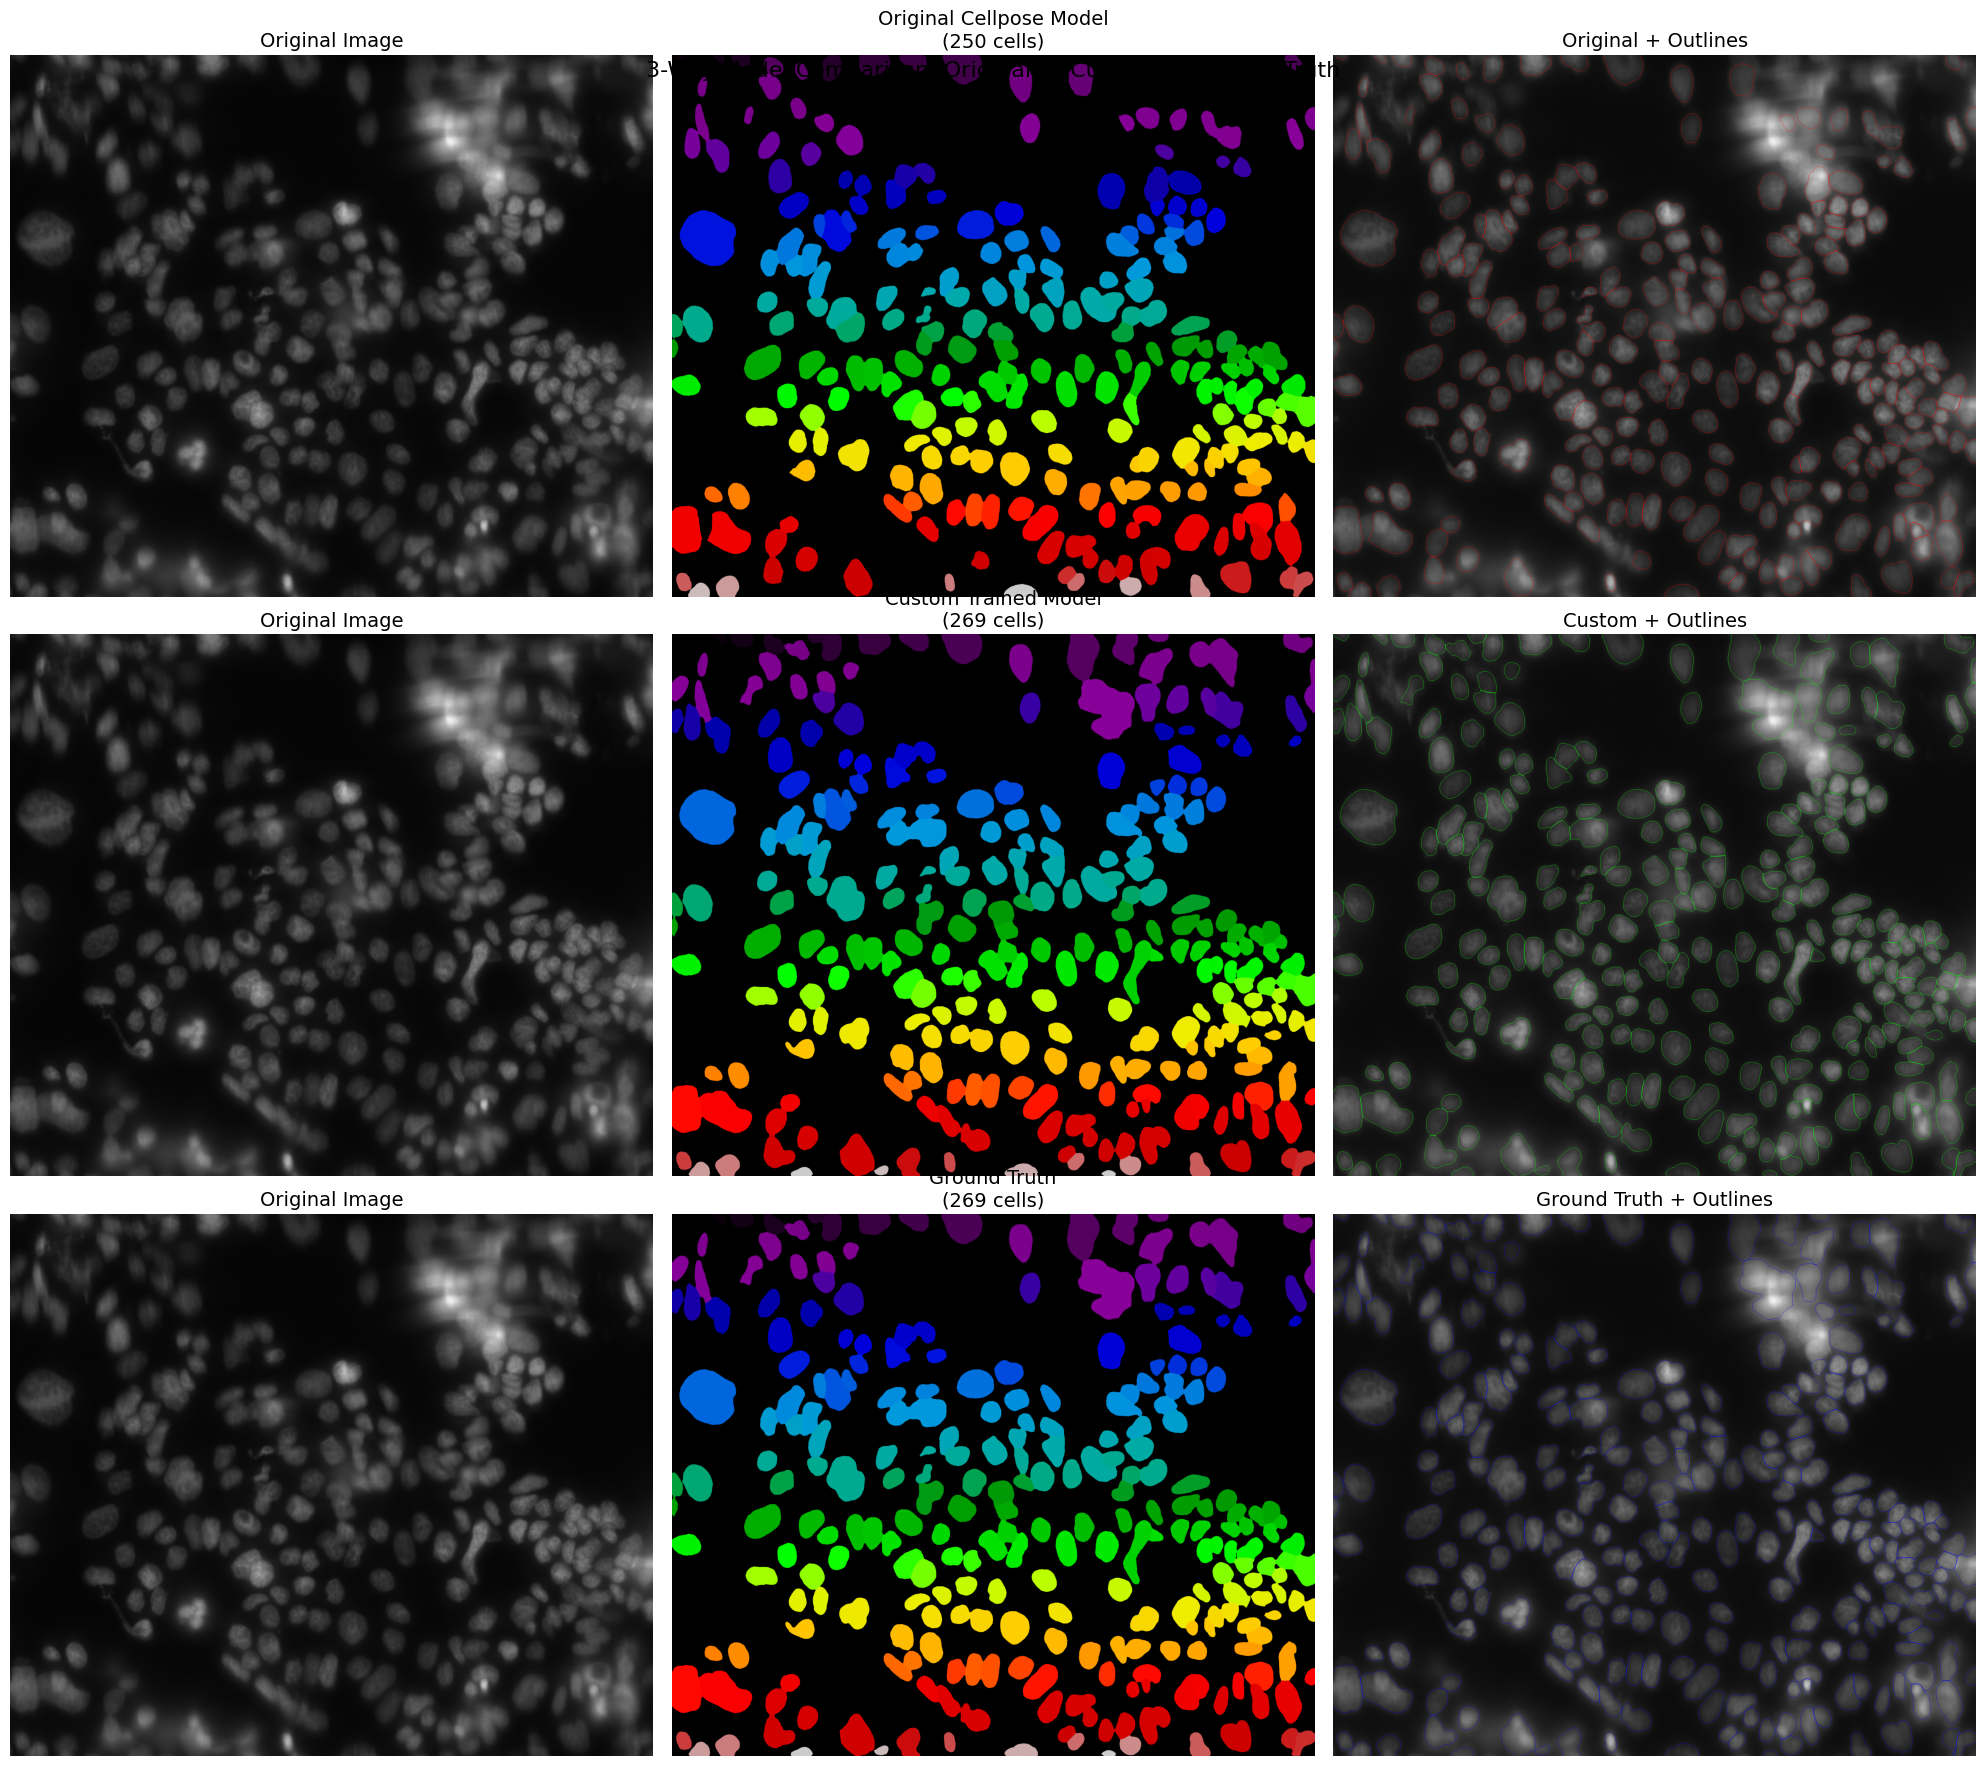


🔬 COMPREHENSIVE MODEL COMPARISON ANALYSIS
📊 CELL COUNT RESULTS:
   Original Cellpose model:  250 cells
   Custom trained model:     269 cells
   Ground Truth:             269 cells

📈 MODEL COMPARISONS:
   Custom vs Original:       +19 cells (+7.6%)
   Original vs Ground Truth:  -19 cells (-7.1%)
   Custom vs Ground Truth:     +0 cells (+0.0%)

🎯 PERFORMANCE ASSESSMENT:
   Original model accuracy:  92.9% (vs ground truth)
   Custom model accuracy:    100.0% (vs ground truth)
   ✅ Custom model is 7.1% MORE accurate!

🏆 BEST PERFORMER:
   🥇 Custom Trained Model (closest to ground truth)


In [28]:
# Load ground truth segmentation for comparison
import os
test_img_basename = os.path.splitext(os.path.basename(test_img_path))[0]
ground_truth_path = f'test/{test_img_basename}_seg.npy'

print(f"🔍 Looking for ground truth: {ground_truth_path}")

# Load ground truth if it exists
if os.path.exists(ground_truth_path):
    try:
        # Try loading as a dictionary first (Cellpose format)
        ground_truth_data = np.load(ground_truth_path, allow_pickle=True).item()
        
        if isinstance(ground_truth_data, dict):
            print(f"📊 Ground truth format: Dictionary with keys: {list(ground_truth_data.keys())}")
            # Check for common keys
            if 'masks' in ground_truth_data:
                ground_truth_masks = ground_truth_data['masks']
                print(f"   Using 'masks' key from dictionary")
            elif 'seg' in ground_truth_data:
                ground_truth_masks = ground_truth_data['seg']
                print(f"   Using 'seg' key from dictionary")
            else:
                # Use the first available array-like value
                for key, value in ground_truth_data.items():
                    if isinstance(value, np.ndarray) and value.ndim == 2:
                        ground_truth_masks = value
                        print(f"   Using '{key}' key as segmentation mask")
                        break
                else:
                    raise ValueError("No suitable 2D array found in dictionary")
        else:
            # Direct numpy array
            ground_truth_masks = ground_truth_data
            print(f"📊 Ground truth format: Direct numpy array")
            
        # Validate the ground truth masks
        print(f"   Shape: {ground_truth_masks.shape}")
        print(f"   Data type: {ground_truth_masks.dtype}")
        print(f"   Value range: {ground_truth_masks.min()} to {ground_truth_masks.max()}")
        
        ground_truth_count = len(np.unique(ground_truth_masks)) - 1
        print(f"✅ Loaded ground truth: {ground_truth_path}")
        print(f"   Ground truth contains: {ground_truth_count} cells")
        
    except Exception as e:
        print(f"❌ Error loading ground truth: {e}")
        ground_truth_masks = None
        ground_truth_count = None
else:
    ground_truth_masks = None
    ground_truth_count = None
    print(f"⚠️  Ground truth not found: {ground_truth_path}")
    
    # Show available _seg.npy files for reference
    seg_files = [f for f in os.listdir('test') if f.endswith('_seg.npy')]
    if seg_files:
        print(f"📋 Available ground truth files in test folder:")
        for f in seg_files:
            print(f"   - {f}")
    else:
        print(f"📋 No _seg.npy files found in test folder")

# Enhanced 3-way comparison visualization
if ground_truth_masks is not None:
    fig, axs = plt.subplots(3, 3, figsize=(20, 18))
    n_rows = 3
else:
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    n_rows = 2

# Prepare image for display
if test_image.ndim == 3 and test_image.shape[0] <= 4:
    display_img = np.moveaxis(test_image, 0, -1)
else:
    display_img = test_image

# Use first channel for grayscale display
if display_img.ndim == 3:
    base_img = display_img[..., 0]
else:
    base_img = display_img

# Normalize for display
if base_img.max() > 255:
    base_img = (base_img / base_img.max() * 255).astype(np.uint8)

# Row 1: Original pre-trained model results
axs[0, 0].imshow(base_img, cmap='gray')
axs[0, 0].set_title('Original Image', fontsize=14)
axs[0, 0].axis('off')

axs[0, 1].imshow(original_result, cmap='nipy_spectral')
axs[0, 1].set_title(f'Original Cellpose Model\n({len(np.unique(original_result)) - 1} cells)', fontsize=14)
axs[0, 1].axis('off')

# Original model with outlines
original_outlines = find_boundaries(original_result, mode='inner')
img_with_original_outlines = np.stack([base_img] * 3, axis=-1)
img_with_original_outlines[original_outlines] = [255, 0, 0]  # Red outlines
axs[0, 2].imshow(img_with_original_outlines)
axs[0, 2].set_title('Original + Outlines', fontsize=14)
axs[0, 2].axis('off')

# Row 2: Custom trained model results
axs[1, 0].imshow(base_img, cmap='gray')
axs[1, 0].set_title('Original Image', fontsize=14)
axs[1, 0].axis('off')

axs[1, 1].imshow(custom_result, cmap='nipy_spectral')
axs[1, 1].set_title(f'Custom Trained Model\n({len(np.unique(custom_result)) - 1} cells)', fontsize=14)
axs[1, 1].axis('off')

# Custom model with outlines
custom_outlines = find_boundaries(custom_result, mode='inner')
img_with_custom_outlines = np.stack([base_img] * 3, axis=-1)
img_with_custom_outlines[custom_outlines] = [0, 255, 0]  # Green outlines
axs[1, 2].imshow(img_with_custom_outlines)
axs[1, 2].set_title('Custom + Outlines', fontsize=14)
axs[1, 2].axis('off')

# Row 3: Ground truth (if available)
if ground_truth_masks is not None:
    axs[2, 0].imshow(base_img, cmap='gray')
    axs[2, 0].set_title('Original Image', fontsize=14)
    axs[2, 0].axis('off')
    
    axs[2, 1].imshow(ground_truth_masks, cmap='nipy_spectral')
    axs[2, 1].set_title(f'Ground Truth\n({ground_truth_count} cells)', fontsize=14)
    axs[2, 1].axis('off')
    
    # Ground truth with outlines
    gt_outlines = find_boundaries(ground_truth_masks, mode='inner')
    img_with_gt_outlines = np.stack([base_img] * 3, axis=-1)
    img_with_gt_outlines[gt_outlines] = [0, 0, 255]  # Blue outlines
    axs[2, 2].imshow(img_with_gt_outlines)
    axs[2, 2].set_title('Ground Truth + Outlines', fontsize=14)
    axs[2, 2].axis('off')

if ground_truth_masks is not None:
    plt.suptitle('3-Way Model Comparison: Original vs Custom vs Ground Truth', fontsize=16, y=0.95)
else:
    plt.suptitle('Model Comparison: Original vs Custom Trained', fontsize=16, y=0.95)

plt.tight_layout()
plt.show()

# Enhanced comparison statistics
print("\n" + "="*60)
print("🔬 COMPREHENSIVE MODEL COMPARISON ANALYSIS")
print("="*60)

original_count = len(np.unique(original_result)) - 1
custom_count = len(np.unique(custom_result)) - 1

print(f"📊 CELL COUNT RESULTS:")
print(f"   Original Cellpose model: {original_count:4d} cells")
print(f"   Custom trained model:    {custom_count:4d} cells")
if ground_truth_count is not None:
    print(f"   Ground Truth:            {ground_truth_count:4d} cells")

print(f"\n📈 MODEL COMPARISONS:")

# Original vs Custom
diff_orig_custom = custom_count - original_count
print(f"   Custom vs Original:      {diff_orig_custom:+4d} cells ({(diff_orig_custom/original_count*100):+.1f}%)")

if ground_truth_count is not None:
    # Original vs Ground Truth
    diff_orig_gt = original_count - ground_truth_count
    print(f"   Original vs Ground Truth: {diff_orig_gt:+4d} cells ({(diff_orig_gt/ground_truth_count*100):+.1f}%)")
    
    # Custom vs Ground Truth
    diff_custom_gt = custom_count - ground_truth_count
    print(f"   Custom vs Ground Truth:   {diff_custom_gt:+4d} cells ({(diff_custom_gt/ground_truth_count*100):+.1f}%)")

print(f"\n🎯 PERFORMANCE ASSESSMENT:")

if ground_truth_count is not None:
    # Calculate accuracy metrics
    orig_accuracy = 100 - abs(diff_orig_gt) / ground_truth_count * 100
    custom_accuracy = 100 - abs(diff_custom_gt) / ground_truth_count * 100
    
    print(f"   Original model accuracy:  {orig_accuracy:.1f}% (vs ground truth)")
    print(f"   Custom model accuracy:    {custom_accuracy:.1f}% (vs ground truth)")
    
    if custom_accuracy > orig_accuracy:
        improvement = custom_accuracy - orig_accuracy
        print(f"   ✅ Custom model is {improvement:.1f}% MORE accurate!")
    elif orig_accuracy > custom_accuracy:
        degradation = orig_accuracy - custom_accuracy
        print(f"   ⚠️  Custom model is {degradation:.1f}% LESS accurate")
    else:
        print(f"   ➖ Both models have equal accuracy")
        
    # Best performer
    print(f"\n🏆 BEST PERFORMER:")
    if custom_accuracy > orig_accuracy:
        print(f"   🥇 Custom Trained Model (closest to ground truth)")
    elif orig_accuracy > custom_accuracy:
        print(f"   🥇 Original Cellpose Model (closest to ground truth)")
    else:
        print(f"   🤝 Tie between both models")
else:
    print(f"   📊 Without ground truth, comparing models directly:")
    if diff_orig_custom > 0:
        print(f"   ✅ Custom model detected {diff_orig_custom} MORE cells (+{(diff_orig_custom/original_count*100):+.1f}%)")
    elif diff_orig_custom < 0:
        print(f"   ⚠️  Custom model detected {abs(diff_orig_custom)} FEWER cells ({(diff_orig_custom/original_count*100):+.1f}%)")
    else:
        print(f"   ➖ Both models detected the same number of cells")

print("="*60)

# Why Original Nuclei Model Failed

Let's analyze why the pre-trained nuclei model didn't work on your DDQ images.

# Save Comparison Results

Save all comparison outputs in an organized folder structure for each image.

# Process All Test Images

Run comparison and save results for all test images automatically.

# Improved Model Comparison Saving

Save comparison results in organized folder structure with subfolders for different types of outputs.

# Run Model Comparison for All Test Images

Process all test images and save organized comparison results.